In [ ]:
import tensorflow as tf
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:
model_name = "google/electra-base-discriminator"
tokenizer = ElectraTokenizer.from_pretrained(model_name)
model = TFElectraForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some layers from the model checkpoint at google/electra-base-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving augmented_train_data.csv to augmented_train_data.csv
Saving test_dataset.csv to test_dataset.csv


In [ ]:
import pandas as pd
import time
train_df = pd.read_csv('augmented_train_data.csv')
test_df = pd.read_csv('test_dataset.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (1960, 2)
Test shape: (424, 2)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_df['text'], train_df['label'], test_size=0.2, random_state = 36312401)

In [ ]:
def tokenize(texts, labels):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="tf"
    )
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    return dataset

In [ ]:
train_dataset = tokenize(X_train.tolist(), y_train.tolist()).shuffle(1000).batch(32)
val_dataset   = tokenize(X_val.tolist(), y_val.tolist()).batch(32)
test_dataset  = tokenize(test_df['text'].tolist(), test_df['label'].tolist()).batch(32)

In [ ]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.metrics.SparseCategoricalAccuracy()]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
checkpoint_dir = "./electra_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, "best_model.h5"),
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [ ]:
start_time = time.time()

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=callbacks
)

print("Training time:", round(time.time() - start_time, 2), "seconds")

Epoch 1/5
49/49 [==============================] - ETA: 0s - loss: 0.3181 - sparse_categorical_accuracy: 0.8827
Epoch 1: val_loss improved from inf to 0.05085, saving model to ./electra_checkpoints/best_model.h5
49/49 [==============================] - 90s 935ms/step - loss: 0.3181 - sparse_categorical_accuracy: 0.8827 - val_loss: 0.0508 - val_sparse_categorical_accuracy: 0.9949
Epoch 2/5
49/49 [==============================] - ETA: 0s - loss: 0.0350 - sparse_categorical_accuracy: 0.9955
Epoch 2: val_loss improved from 0.05085 to 0.01043, saving model to ./electra_checkpoints/best_model.h5
49/49 [==============================] - 50s 1s/step - loss: 0.0350 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.0104 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/5
49/49 [==============================] - ETA: 0s - loss: 0.0157 - sparse_categorical_accuracy: 0.9968
Epoch 3: val_loss improved from 0.01043 to 0.00588, saving model to ./electra_checkpoints/best_model.h5
49/49 [============

In [ ]:
loss, acc = model.evaluate(test_dataset)
print(f"\nTest Accuracy: {acc:.4f}")

14/14 [==============================] - 11s 251ms/step - loss: 0.0526 - sparse_categorical_accuracy: 0.9882

Test Accuracy: 0.9882


In [ ]:
pred_logits = model.predict(test_dataset).logits
pred_labels = tf.math.argmax(pred_logits, axis=1).numpy()

14/14 [==============================] - 7s 254ms/step


In [ ]:
print("\nFinal Test Set Evaluation:")
print(classification_report(test_df['label'].tolist(), pred_labels))


Final Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       170
           1       0.98      1.00      0.99       254

    accuracy                           0.99       424
   macro avg       0.99      0.99      0.99       424
weighted avg       0.99      0.99      0.99       424



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_df['label'].tolist(), pred_labels)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[166   4]
 [  1 253]]


ROC AUC Score: 0.9998
PR AUC Score: 0.9999


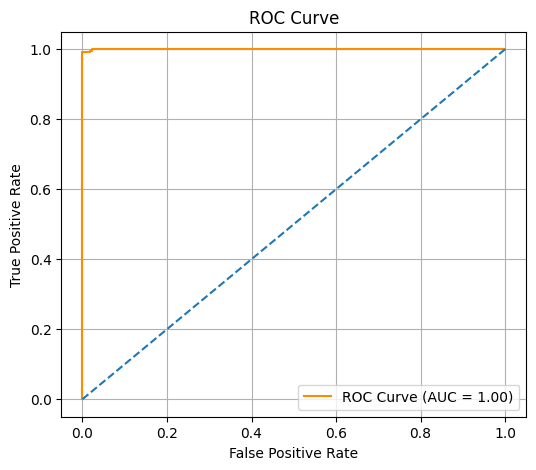

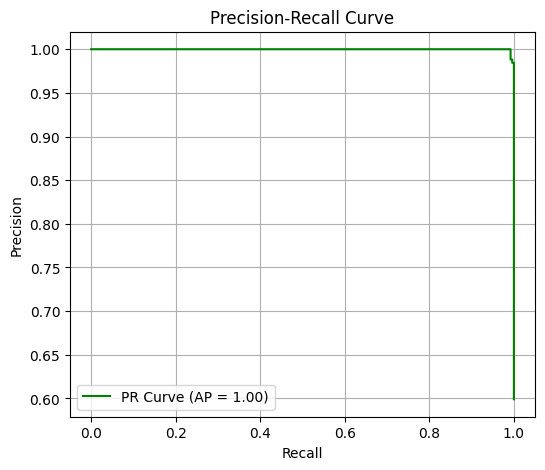

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

y_true = test_df['label'].tolist()
y_scores = tf.nn.softmax(pred_logits, axis=1).numpy()[:, 1]  # Use logits to get probability of class 1

# Scores
roc_auc = roc_auc_score(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"PR AUC Score: {pr_auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='green', label=f'PR Curve (AP = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()